In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
directory = r'C:\Users\Rushi\Desktop\ML_assign_3'
file_name = 'co2_mm_mlo.csv'

file_path = os.path.join(directory, file_name)
df = pd.read_csv(file_path, skiprows=40, header=0)
df['Date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df.head()

,year,month,decimal date,average,deseasonalized,ndays,sdev,unc,Date
0,1958,3,1958.2027,315.70,314.43,-1,-9.99,-0.99,1958-03-01
1,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99,1958-04-01
2,1958,5,1958.3699,317.51,314.71,-1,-9.99,-0.99,1958-05-01
3,1958,6,1958.4548,317.24,315.14,-1,-9.99,-0.99,1958-06-01
4,1958,7,1958.5370,315.86,315.18,-1,-9.99,-0.99,1958-07-01


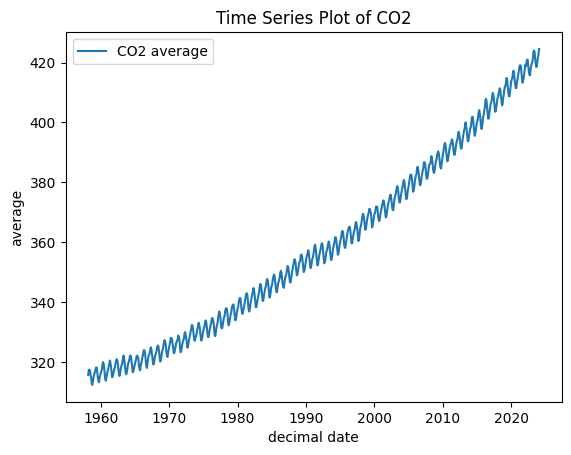

In [3]:
# Plotting the CO2 time series data

plt.plot(df['Date'], df['average'], label='CO2 average')
plt.xlabel('decimal date')
plt.ylabel('average')
plt.title('Time Series Plot of CO2')
plt.legend()
plt.show()

In [4]:
# Making a new_df

new_df = df.set_index('Date')['average']  # Setting 'Date' column as index and selecting 'average' column
new_df = pd.DataFrame(new_df)
new_df

,average
Date,
1958-03-01,315.70
1958-04-01,317.45
1958-05-01,317.51
1958-06-01,317.24
1958-07-01,315.86
...,...
2023-10-01,418.82
2023-11-01,420.46
2023-12-01,421.86


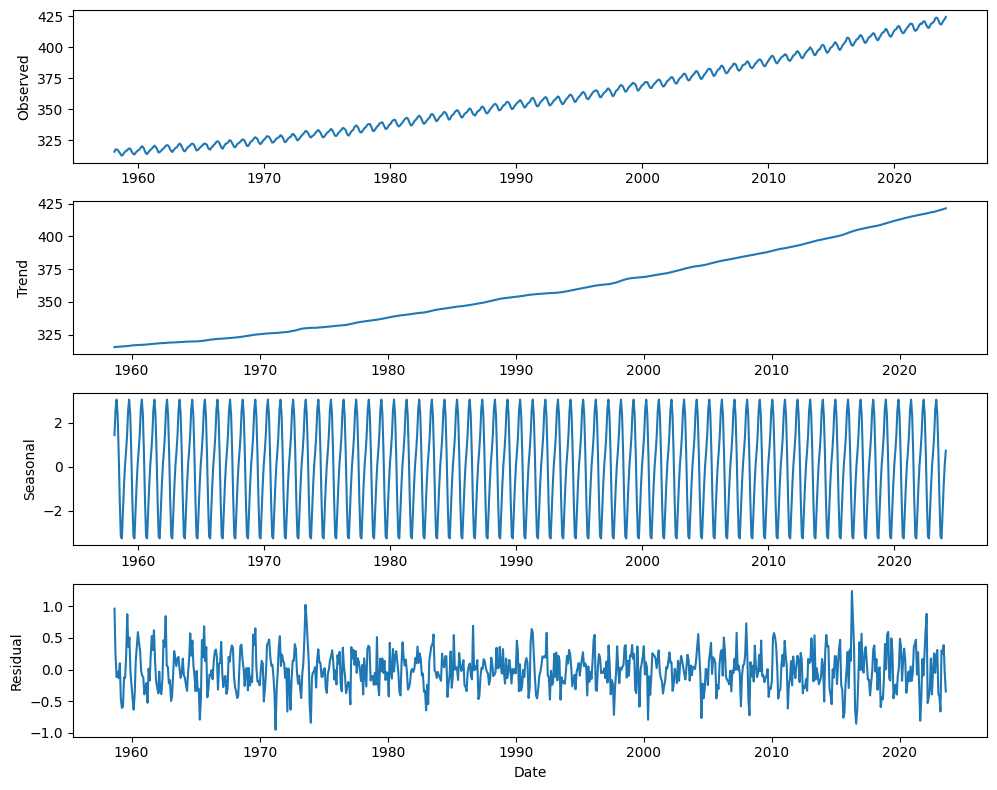

In [5]:
# Decomposing the CO2 data

decompose_data = seasonal_decompose(new_df, model='additive')

# Plot each component separately
plt.figure(figsize=(10, 8))

plt.subplot(411)
plt.plot(decompose_data.observed)
plt.ylabel('Observed')

plt.subplot(412)
plt.plot(decompose_data.trend)
plt.ylabel('Trend')

plt.subplot(413)
plt.plot(decompose_data.seasonal)
plt.ylabel('Seasonal')

plt.subplot(414)
plt.plot(decompose_data.resid)
plt.xlabel('Date')
plt.ylabel('Residual')

plt.tight_layout()
plt.show()

In [6]:
# Checking if the time series data is stationary or not

def adf_test(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Test Results:')
    if result[1] > 0.05:
        print('p-value:', result[1])
        print('The time series data is not stationary')
    else:
        print('p-value:', result[1])
        print('The time series data is stationary')

adf_test(new_df['average']) # if p-value is less than 0.05 so the time series is stationary.


ADF Test Results:
p-value: 1.0
The time series data is not stationary


In [7]:
# Apply transformation to the data

new_df['log_average'] = new_df['average'].apply(lambda x: np.log(x))
new_df['log_average_minus_rolling'] = new_df['log_average'] - new_df['log_average'].rolling(window=12).mean()
new_df = new_df.iloc[12:]      # shape is 780*3
adf_test(new_df['log_average_minus_rolling'])
new_df  

ADF Test Results:
p-value: 0.0016702621470611244
The time series data is stationary


,average,log_average,log_average_minus_rolling
Date,,,
1959-03-01,316.65,5.757797,0.003829
1959-04-01,317.72,5.761170,0.007132
1959-05-01,318.29,5.762963,0.008720
1959-06-01,318.15,5.762523,0.008041
1959-07-01,316.54,5.757450,0.002789
...,...,...,...
2023-10-01,418.82,6.037441,-0.004209
2023-11-01,420.46,6.041349,-0.000895
2023-12-01,421.86,6.044674,0.001860


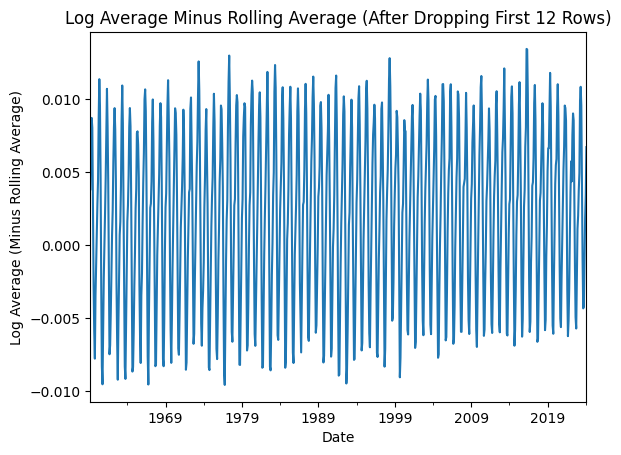

In [8]:
# Stationary Data
new_df['log_average_minus_rolling'].plot()
plt.xlabel('Date')
plt.ylabel('Log Average (Minus Rolling Average)')
plt.title('Log Average Minus Rolling Average (After Dropping First 12 Rows)')
plt.show()

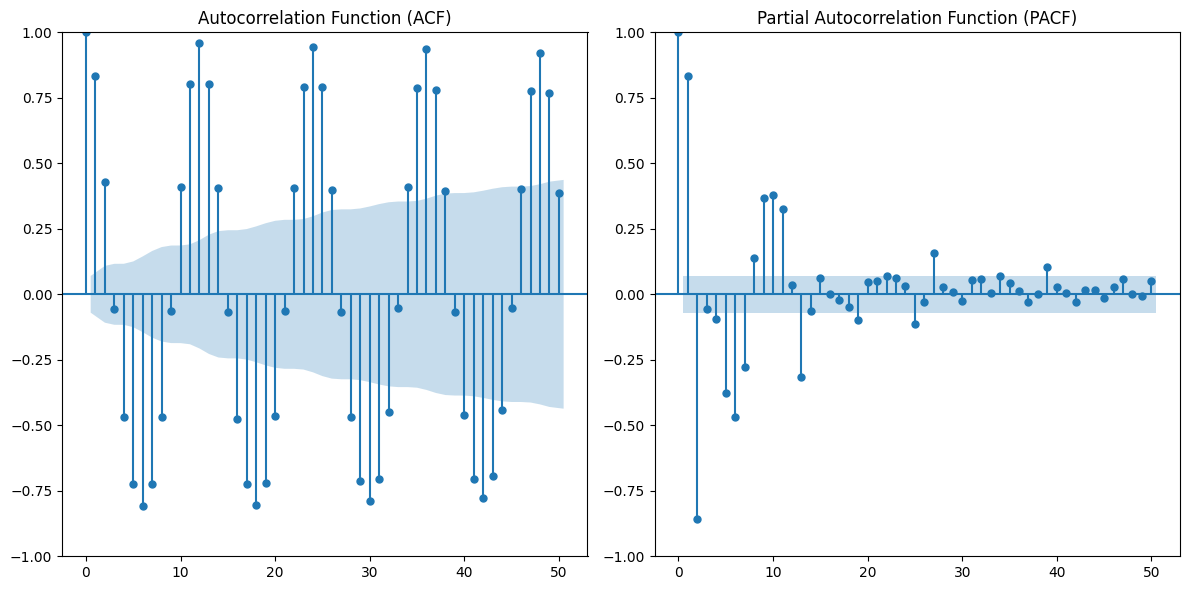

In [9]:
from statsmodels.tsa.stattools import acf, pacf

# Calculate ACF and PACF using the 'log_average_minus_rolling' column from new_df
lag_acf = acf(new_df['log_average_minus_rolling'], nlags=50)
lag_pacf = pacf(new_df['log_average_minus_rolling'], nlags=50)

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF
plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
plot_acf(new_df['log_average_minus_rolling'], lags=50, ax=ax1)
plt.title('Autocorrelation Function (ACF)')

# Plot PACF
ax2 = plt.subplot(122)
plot_pacf(new_df['log_average_minus_rolling'], lags=50, ax=ax2)
plt.title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()



# MA Model

In [10]:
# Using SARIMAX to forecast, for MA

model_MA = sm.tsa.statespace.SARIMAX(new_df['log_average_minus_rolling'], order=(0, 1, 3), seasonal_order = (0, 1, 3, 12))
model_MA_fit = model_MA.fit()

predictions_MA = model_MA_fit.predict(start = '2024-03-01', end = '2029-02-01')
                                     

C:\Users\Rushi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Rushi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [11]:
# Assuming predictions is the output from your model

predictions_series = predictions_MA  # Assuming predictions is a tuple with predictions as the first element
predicted_MA_df = pd.DataFrame(predictions_series, columns=['predicted_mean'])
predicted_MA_df = predicted_MA_df.rename(columns={'predicted_mean': 'predicted_values'})
predicted_MA_df.head()


,predicted_values
2024-03-01,0.007335
2024-04-01,0.010867
2024-05-01,0.012011
2024-06-01,0.010315
2024-07-01,0.005274


In [12]:
# Inverse function for rolling

values_MA = new_df['log_average'][-12:]
new_array_MA = []
for i in range(len(predicted_MA_df['predicted_values'])):
    temp = np.mean(values_MA)
    new_value_MA = temp+predicted_MA_df['predicted_values'][i]
    new_array_MA.append(new_value_MA)
    values_MA= np.append(values_MA[1:], new_value_MA)
predicted_MA_df['predicted_rolling_plus_values'] = np.array(new_array_MA)

C:\Users\Rushi\AppData\Local\Temp\ipykernel_9664\2338628827.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_value_MA = temp+predicted_MA_df['predicted_values'][i]


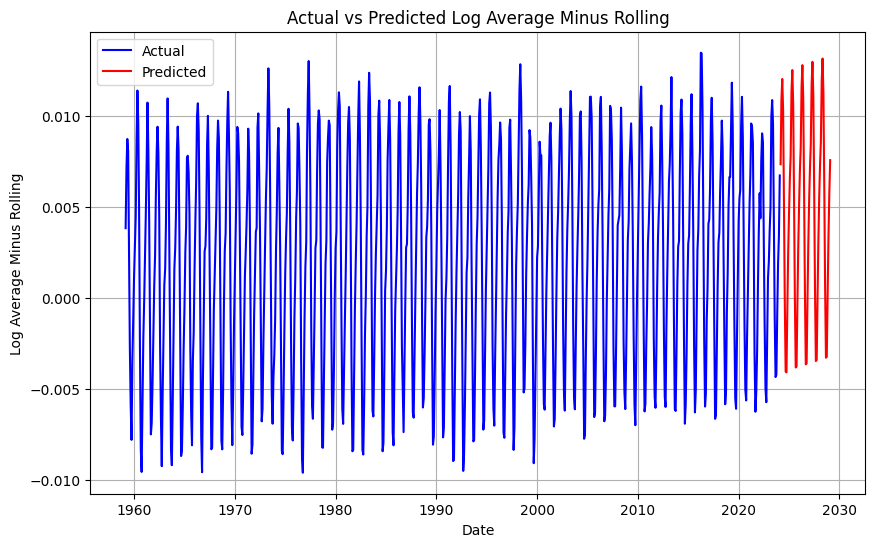

In [13]:
# New dataframe of intial and predicted values
concat_MA_df = pd.concat([new_df['log_average_minus_rolling'], predicted_MA_df])

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(concat_MA_df.index, concat_MA_df['log_average_minus_rolling'], label='Actual', color='blue')
plt.plot(predicted_MA_df.index, predicted_MA_df['predicted_values'], label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Log Average Minus Rolling')
plt.title('Actual vs Predicted Log Average Minus Rolling')
plt.legend()
plt.grid(True)
plt.show()


In [14]:
concat_MA_df['predicted_scaled_up'] = np.exp(concat_MA_df['predicted_rolling_plus_values'])
concat_MA_df

,log_average_minus_rolling,predicted_values,predicted_rolling_plus_values,predicted_scaled_up
1959-03-01,0.003829,NaN,NaN,NaN
1959-04-01,0.007132,NaN,NaN,NaN
1959-05-01,0.008720,NaN,NaN,NaN
1959-06-01,0.008041,NaN,NaN,NaN
1959-07-01,0.002789,NaN,NaN,NaN
...,...,...,...,...
2028-10-01,NaN,-0.003223,6.080845,437.398591
2028-11-01,NaN,0.000186,6.085050,439.241652
2028-12-01,NaN,0.003299,6.088960,440.962735
2029-01-01,NaN,0.005748,6.092209,442.397694


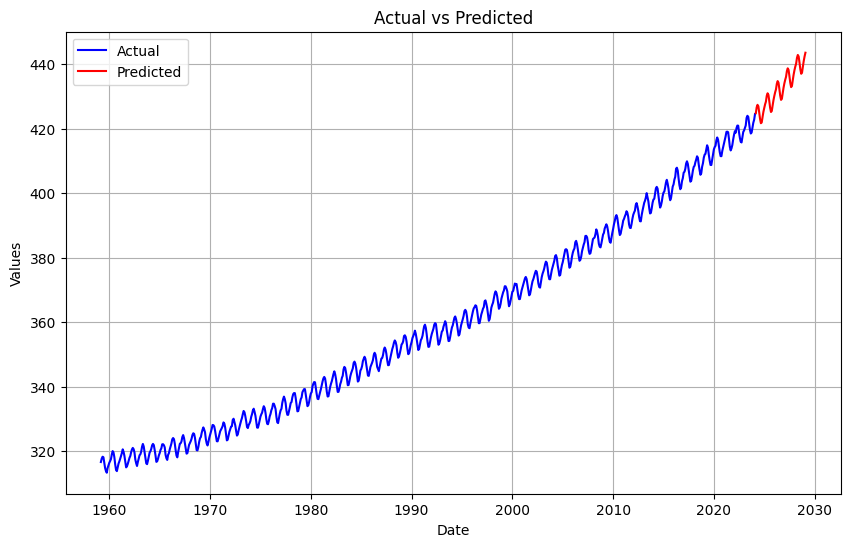

In [15]:
# Ploting actual vs predicted
plt.figure(figsize=(10, 6))

# Plot actual values
sns.lineplot(data=new_df['average'], label='Actual', color='blue')

# Plot predicted values
sns.lineplot(data=concat_MA_df['predicted_scaled_up'], label='Predicted', color='red')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

In [16]:
concat_MA_df

,log_average_minus_rolling,predicted_values,predicted_rolling_plus_values,predicted_scaled_up
1959-03-01,0.003829,NaN,NaN,NaN
1959-04-01,0.007132,NaN,NaN,NaN
1959-05-01,0.008720,NaN,NaN,NaN
1959-06-01,0.008041,NaN,NaN,NaN
1959-07-01,0.002789,NaN,NaN,NaN
...,...,...,...,...
2028-10-01,NaN,-0.003223,6.080845,437.398591
2028-11-01,NaN,0.000186,6.085050,439.241652
2028-12-01,NaN,0.003299,6.088960,440.962735
2029-01-01,NaN,0.005748,6.092209,442.397694


# ARMA

In [17]:
# Using SARIMAX to forecast, for ARMA

model_ARMA = sm.tsa.statespace.SARIMAX(new_df['log_average_minus_rolling'], order=(3, 1, 3), seasonal_order = (3, 1, 3, 12))
model_ARMA_fit = model_ARMA.fit()

predictions_ARMA = model_ARMA_fit.predict(start = '2024-03-01', end = '2029-02-01')
                                     

C:\Users\Rushi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Rushi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\Rushi\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [18]:
# Assuming predictions is the output from your model

predictions_series = predictions_ARMA  # Assuming predictions is a tuple with predictions as the first element
predicted_ARMA_df = pd.DataFrame(predictions_series, columns=['predicted_mean'])
predicted_ARMA_df = predicted_ARMA_df.rename(columns={'predicted_mean': 'predicted_values'})
predicted_ARMA_df.head()


,predicted_values
2024-03-01,0.007134
2024-04-01,0.010688
2024-05-01,0.011886
2024-06-01,0.010212
2024-07-01,0.005020


In [19]:
# Inverse function for rolling

values_ARMA = new_df['log_average'][-12:]
new_array_ARMA = []
for i in range(len(predicted_ARMA_df['predicted_values'])):
    temp = np.mean(values_ARMA)
    new_value_ARMA = temp+predicted_ARMA_df['predicted_values'][i]
    new_array_ARMA.append(new_value_ARMA)
    values_ARMA= np.append(values_ARMA[1:], new_value_ARMA)
predicted_ARMA_df['predicted_rolling_plus_values'] = np.array(new_array_ARMA)

C:\Users\Rushi\AppData\Local\Temp\ipykernel_9664\3892985986.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_value_ARMA = temp+predicted_ARMA_df['predicted_values'][i]


In [20]:
# making dataframe for actual vs predicted

concat_ARMA_df = pd.concat((new_df['log_average_minus_rolling'], predicted_ARMA_df['predicted_values']))
concat_ARMA_df = concat_ARMA_df.reset_index()
concat_ARMA_df.columns = ['Date', 'Values']
concat_ARMA_df['Actual'] = concat_ARMA_df['Values'].where(concat_ARMA_df['Date'].isin(new_df.index), None)
concat_ARMA_df['Predicted'] = concat_ARMA_df['Values'].where(concat_ARMA_df['Date'].isin(predicted_ARMA_df.index), None)
concat_ARMA_df.set_index('Date', inplace=True)
concat_ARMA_df.drop(columns='Values', inplace=True)

concat_ARMA_df


,Actual,Predicted
Date,,
1959-03-01,0.003829,NaN
1959-04-01,0.007132,NaN
1959-05-01,0.008720,NaN
1959-06-01,0.008041,NaN
1959-07-01,0.002789,NaN
...,...,...
2028-10-01,NaN,-0.003092
2028-11-01,NaN,0.000302
2028-12-01,NaN,0.003307


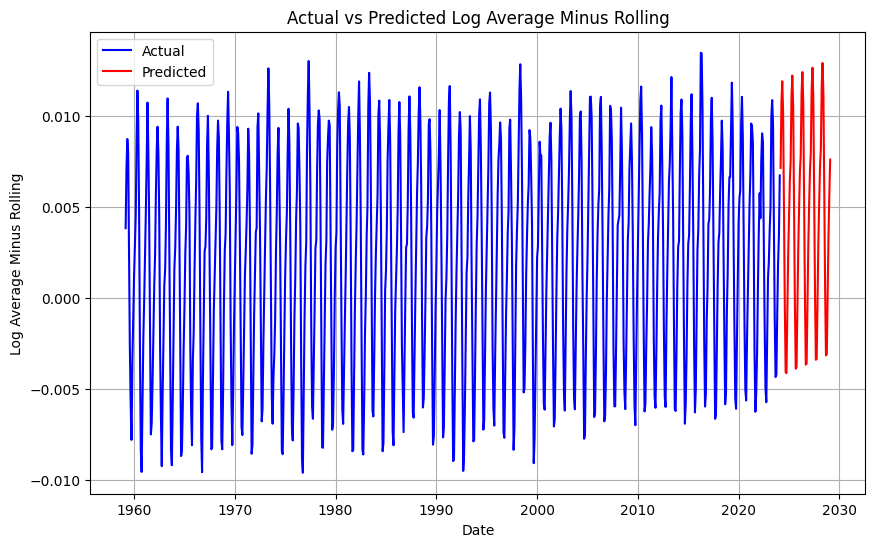

In [21]:
# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(concat_ARMA_df.index, concat_ARMA_df['Actual'], label='Actual', color='blue')
plt.plot(concat_ARMA_df.index, concat_ARMA_df['Predicted'], label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Log Average Minus Rolling')
plt.title('Actual vs Predicted Log Average Minus Rolling')
plt.legend()
plt.grid(True)
plt.show()


In [22]:
concat_ARMA_df['predicted_rolling_plus_values'] = predicted_ARMA_df['predicted_rolling_plus_values']
concat_ARMA_df['predicted_scaled_up'] = np.exp(concat_ARMA_df['predicted_rolling_plus_values'])
concat_ARMA_df

,Actual,Predicted,predicted_rolling_plus_values,predicted_scaled_up
Date,,,,
1959-03-01,0.003829,NaN,NaN,NaN
1959-04-01,0.007132,NaN,NaN,NaN
1959-05-01,0.008720,NaN,NaN,NaN
1959-06-01,0.008041,NaN,NaN,NaN
1959-07-01,0.002789,NaN,NaN,NaN
...,...,...,...,...
2028-10-01,NaN,-0.003092,6.079626,436.865645
2028-11-01,NaN,0.000302,6.083803,438.694294
2028-12-01,NaN,0.003307,6.087593,440.360082


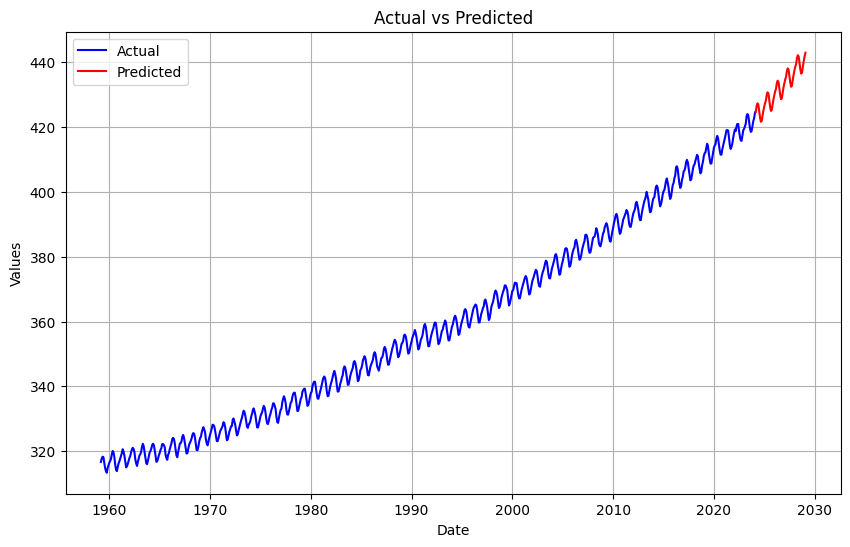

In [23]:
# Ploting actual vs predicted
plt.figure(figsize=(10, 6))

# Plot actual values
sns.lineplot(data=new_df['average'], label='Actual', color='blue')

# Plot predicted values
sns.lineplot(data=concat_ARMA_df['predicted_scaled_up'], label='Predicted', color='red')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

# MLP Model

In [24]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

#Set Training & Test Data
n_train = int(len(new_df['log_average_minus_rolling']))
train = pd.DataFrame(new_df['log_average_minus_rolling'].iloc[0:n_train])

#Convert to Time Series Data
def get_timeseries(x, n_steps=1):
    x_ts, y_ts = [], []
    for ii in range(len(x) - n_steps):
        v = x.iloc[ii:(ii + n_steps)].values
        x_ts.append(v)
        w = x.iloc[ii + n_steps].values
        y_ts.append(w)
    return np.array(x_ts), np.array(y_ts)


n_steps = 13
n_features = 1
x_train, y_train = get_timeseries(train, n_steps)

#Setup Neural Network
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_steps))
model.add(Dense(50, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer=Adam(0.001))

#Fit Model
history = model.fit(x_train, y_train,epochs=350,batch_size=32,validation_split=0.1)


C:\Users\Rushi\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/350
22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 2.7128e-05 - val_loss: 5.8228e-06
Epoch 2/350
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2.5945e-06 - val_loss: 1.4338e-06
Epoch 3/350
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8530e-06 - val_loss: 2.4558e-06
Epoch 4/350
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.8026e-06 - val_loss: 1.5638e-06
Epoch 5/350
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.6509e-06 - val_loss: 2.0745e-06
Epoch 6/350
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4832e-06 - val_loss: 1.5268e-06
Epoch 7/350
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.3424e-06 - val_loss: 1.3882e-06
Epoch 8/350
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.2634e-06 - val_loss: 2.7625e-06
Epoch 9/350
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7429e-06 - val_loss: 1.1946e-06
Epoch 10/350
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.5782e-06 - val_loss: 1.1311e-06
Epoch 11/350
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.7339e-

In [25]:
# Forecasting next 60 datapoints
forecasted_values = []
last_input = x_train[-1]  # Initialize last input with the last data points from training data

for _ in range(60):
    last_input_reshaped = last_input.reshape(1, n_steps)
    pred = model.predict(last_input_reshaped)[0][0]
    forecasted_values.append(pred)
    last_input = np.append(last_input[1:], pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━

In [26]:
# Converting it to dataframe
predicted_MA_df_index = predicted_MA_df.index.tolist()  # Extract index as list
forecasted_df = pd.DataFrame({'predicted_values': forecasted_values}, index=predicted_MA_df_index)
forecasted_df.head()

,predicted_values
2024-03-01,0.005321
2024-04-01,0.007090
2024-05-01,0.009933
2024-06-01,0.010797
2024-07-01,0.008824


In [27]:
# inverse function of rolling
values = new_df['log_average'][-12:]
new_array = []
for i in range(len(forecasted_df['predicted_values'])):
    temp = np.mean(values)
    new_value = temp+ forecasted_df['predicted_values'][i]
    new_array.append(new_value)
    values= np.append(values[1:], new_value)
forecasted_df['predicted_rolling_plus_values'] = np.array(new_array)

C:\Users\Rushi\AppData\Local\Temp\ipykernel_9664\661373752.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  new_value = temp+ forecasted_df['predicted_values'][i]


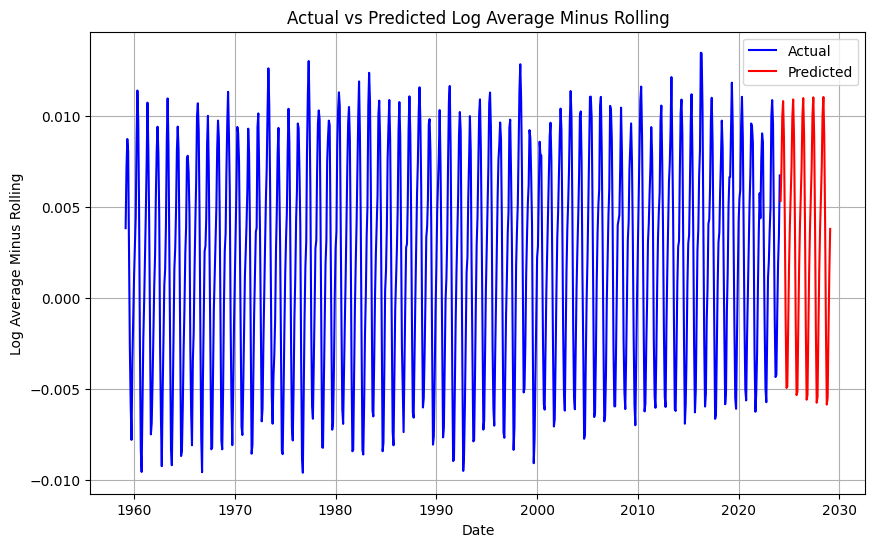

In [28]:
# Ploting stationary actual vs predicted
concat_MLP_df = pd.concat([new_df['log_average_minus_rolling'], forecasted_df])

# Plot the graph
plt.figure(figsize=(10, 6))
plt.plot(concat_MLP_df.index, concat_MLP_df['log_average_minus_rolling'], label='Actual', color='blue')
plt.plot(forecasted_df.index, forecasted_df['predicted_values'], label='Predicted', color='red')
plt.xlabel('Date')
plt.ylabel('Log Average Minus Rolling')
plt.title('Actual vs Predicted Log Average Minus Rolling')
plt.legend()
plt.grid(True)
plt.show()

In [29]:
concat_MLP_df['predicted_scaled_up'] = np.exp(concat_MLP_df['predicted_rolling_plus_values'])
concat_MLP_df

,log_average_minus_rolling,predicted_values,predicted_rolling_plus_values,predicted_scaled_up
1959-03-01,0.003829,NaN,NaN,NaN
1959-04-01,0.007132,NaN,NaN,NaN
1959-05-01,0.008720,NaN,NaN,NaN
1959-06-01,0.008041,NaN,NaN,NaN
1959-07-01,0.002789,NaN,NaN,NaN
...,...,...,...,...
2028-10-01,NaN,-0.005841,6.066196,431.037909
2028-11-01,NaN,-0.005468,6.067036,431.400293
2028-12-01,NaN,-0.001953,6.071023,433.123502
2029-01-01,NaN,0.001409,6.074859,434.788353


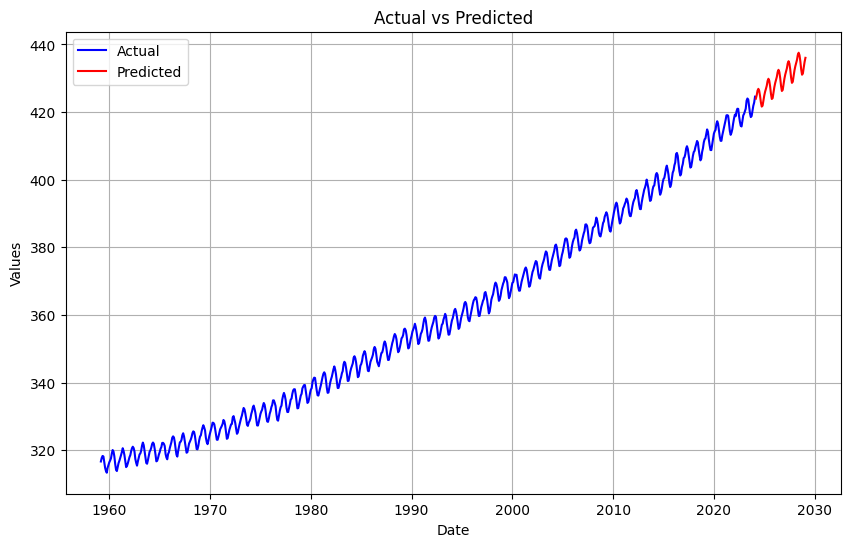

In [31]:
# Actual vs predicted
plt.figure(figsize=(10, 6))

# Plot actual values
sns.lineplot(data=new_df['average'], label='Actual', color='blue')

# Plot predicted values
sns.lineplot(data=concat_MLP_df['predicted_scaled_up'], label='Predicted', color='red')

plt.xlabel('Date')
plt.ylabel('Values')
plt.title('Actual vs Predicted')
plt.legend()
plt.grid(True)
plt.show()

# Comparing all the predicted data, from different model that is MA, ARMA and MLP

In [32]:
compare_df = pd.concat([concat_MA_df['predicted_scaled_up'], concat_ARMA_df['predicted_scaled_up'], concat_MLP_df['predicted_scaled_up']], axis=1)
compare_df.columns = ['MA_predicted', 'ARMA_predicted', 'MLP_predicted']
compare_df = compare_df.dropna()
compare_df.head()

,MA_predicted,ARMA_predicted,MLP_predicted
2024-03-01,424.810848,424.725556,423.956225
2024-04-01,426.635137,426.551709,424.955449
2024-05-01,427.398714,427.331251,426.299773
2024-06-01,426.958527,426.894802,426.860401
2024-07-01,425.084537,424.951733,426.284630


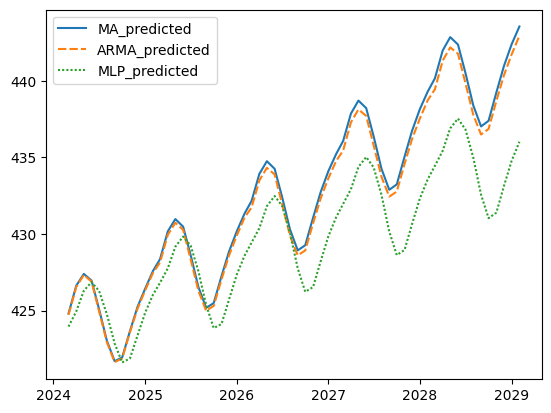

In [33]:
#ploting
sns.lineplot(data=compare_df)
plt.show()

For MA and ARMA model, it takes into account for the previous K terms only and gives the prediction based upon near past values, So it can predict the nuance in the current trend and seasonality both appropiately.

Likewise for MLP, it also takes in previous K terms and predicted the K+1 term, and it provide good plot for seasonlity and also trend.